## MCX simulation Stage 2.2

In [1]:
! pip install pmcx
! pip install numpy pmcx jdata bjdata matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import sys
import os
import pmcx

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
folder_path = '/content/drive/MyDrive/MCX_data'
if folder_path not in sys.path:
    sys.path.append(folder_path)
from FD_msNIRS import mcx_simulation as ms

In [4]:
pmcx.gpuinfo()

[{'name': 'NVIDIA A100-SXM4-40GB',
  'id': 1,
  'devcount': 1,
  'major': 8,
  'minor': 0,
  'globalmem': 42474471424,
  'constmem': 65536,
  'sharedmem': 49152,
  'regcount': 65536,
  'clock': 1410000,
  'sm': 108,
  'core': 6912,
  'autoblock': 64,
  'autothread': 442368,
  'maxgate': 0}]

### MCX Simulation using packgae

In [5]:
import pmcx
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle
from FD_msNIRS import mcx_fft as mf
from FD_msNIRS import extract_freq as ef

In [6]:
g=0.85
wls = [690, 830]
ua = np.array([0.16973, 0.21524])  # cm-1
us_prime = [14.4035703, 10.6959961] # cm-1
us = np.array([x/(1-g) for x in us_prime])
distance = [2, 2.5, 3, 3.5] # cm

In [7]:
us

array([96.023802  , 71.30664067])

In [8]:
# compute ua, distance, and us in mm-1
ua_mm = ua/10
us_mm = us/10
distance_mm = [d*10 for d in distance]

In [9]:
ua_mm

array([0.016973, 0.021524])

In [10]:
us_mm

array([9.6023802 , 7.13066407])

### Run simulations

In [11]:
dictt_ms = {}
for i in range(0, len(distance_mm)):
  d = distance_mm[i]
  print('distance (mm) = ', d)
  for j in range(0, ua_mm.shape[0]):
    print('ua = ', ua_mm[j])
    print('us = ', us_mm[j])
    TPSF, time_unit = ms(ua_mm[j], us_mm[j], g=0.85, n=1.370, distance = d, tend =1e-08, devf = 1000, nphoton = 1.2e8)
    dictt_ms[f'{d}, {wls[j]}'] = [TPSF, time_unit]

distance (mm) =  20
ua =  0.016973
us =  9.602380199999999
nphoton: 1.2e+08
tstart: 0
tstep: 1e-11
tend: 1e-08
maxdetphoton: 1.2e+08
issrcfrom0: 1
autopilot: 1
unitinmm: 1
issaveref: 1
issavedet: 1
ua =  0.021523999999999998
us =  7.130664066666665
nphoton: 1.2e+08
tstart: 0
tstep: 1e-11
tend: 1e-08
maxdetphoton: 1.2e+08
issrcfrom0: 1
autopilot: 1
unitinmm: 1
issaveref: 1
issavedet: 1
distance (mm) =  25.0
ua =  0.016973
us =  9.602380199999999
nphoton: 1.2e+08
tstart: 0
tstep: 1e-11
tend: 1e-08
maxdetphoton: 1.2e+08
issrcfrom0: 1
autopilot: 1
unitinmm: 1
issaveref: 1
issavedet: 1
ua =  0.021523999999999998
us =  7.130664066666665
nphoton: 1.2e+08
tstart: 0
tstep: 1e-11
tend: 1e-08
maxdetphoton: 1.2e+08
issrcfrom0: 1
autopilot: 1
unitinmm: 1
issaveref: 1
issavedet: 1
distance (mm) =  30
ua =  0.016973
us =  9.602380199999999
nphoton: 1.2e+08
tstart: 0
tstep: 1e-11
tend: 1e-08
maxdetphoton: 1.2e+08
issrcfrom0: 1
autopilot: 1
unitinmm: 1
issaveref: 1
issavedet: 1
ua =  0.0215239999999999

In [12]:
target_freq = 110e6
uac = []
udc = []
phase1 = []
phase2 = []

for k, v in dictt_ms.items():
    TPSF, tstep = v
    uac_i, udc_i, p1, p2 = ef(target_freq, TPSF, tend=1e-08, devf=1000)
    uac.append(uac_i)
    udc.append(udc_i)
    phase1.append(p1)
    phase2.append(p2)

In [13]:
udc[0]

np.float64(8.93229061269251e-06)

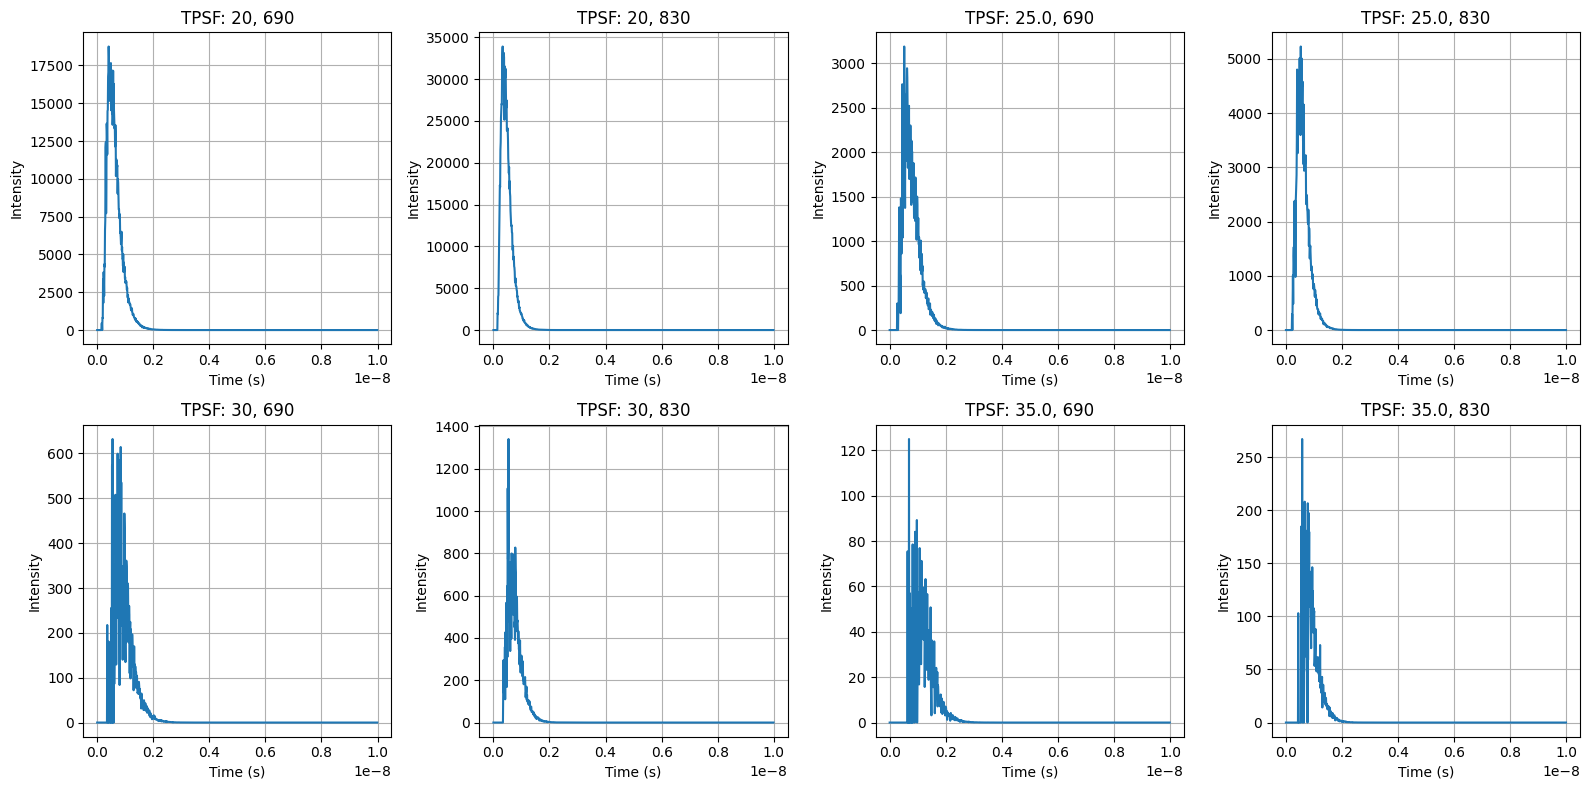

In [14]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 4, figsize=(16, 8))  # 2 rows, 4 columns
axes = axes.flatten()  # Flatten for easy indexing

for idx, (label, (TPSF, time_unit)) in enumerate(dictt_ms.items()):

    # Reconstruct time vector
    t = np.arange(len(TPSF)) * time_unit

    # Plot
    axes[idx].plot(t, TPSF)
    axes[idx].set_title(f"TPSF: {label}")
    axes[idx].set_xlabel("Time (s)")
    axes[idx].set_ylabel("Intensity")
    axes[idx].grid(True)

# Remove empty subplots if any
for i in range(len(dictt_ms), 8):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


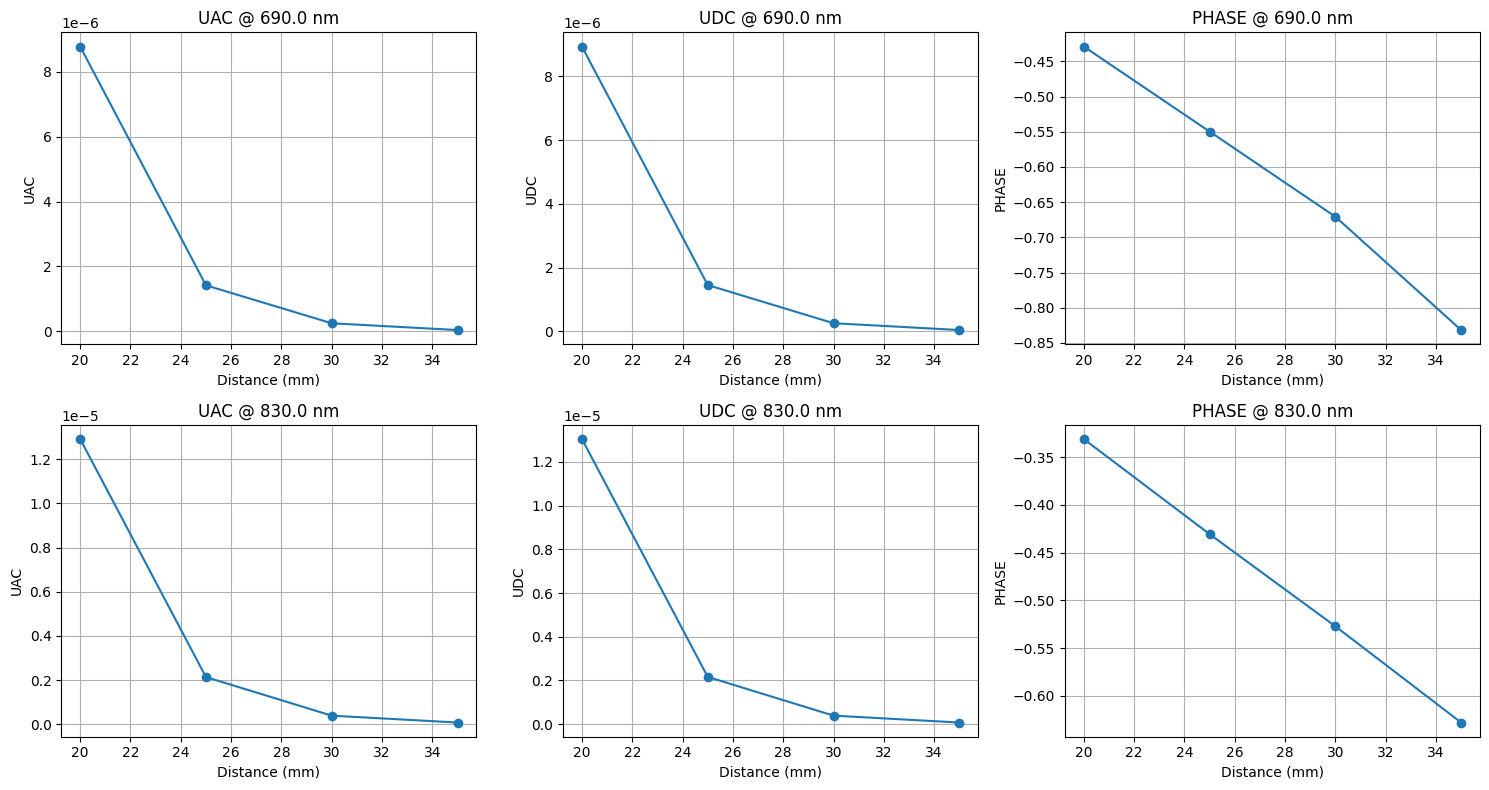

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Group data by wavelength
data_by_wl = {}
for (key, (TPSF, tstep)), uac_i, udc_i, p1, p2 in zip(dictt_ms.items(), uac, udc, phase1, phase2):
    dist_str, wl_str = key.split(',')  # split key: "distance, wavelength"
    wl = float(wl_str.strip())
    d = float(dist_str.strip())

    if wl not in data_by_wl:
        data_by_wl[wl] = {'distance': [], 'uac': [], 'udc': [], 'phase': []}

    data_by_wl[wl]['distance'].append(d)
    data_by_wl[wl]['uac'].append(uac_i)
    data_by_wl[wl]['udc'].append(udc_i)
    data_by_wl[wl]['phase'].append(p1)

# Sort by wavelength
sorted_wls = sorted(data_by_wl.keys())

# Plotting
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
metrics = ['uac', 'udc', 'phase']
titles = ['UAC', 'UDC', 'PHASE']

for row in range(2):
    wl = sorted_wls[row]
    data = data_by_wl[wl]
    distances = data['distance']

    for col in range(3):
        ax = axes[row, col]
        metric = metrics[col]
        ax.plot(distances, data[metric], marker='o')
        ax.set_title(f"{titles[col]} @ {wl} nm")
        ax.set_xlabel("Distance (mm)")
        ax.set_ylabel(titles[col])
        ax.grid(True)

plt.tight_layout()
plt.show()

In [19]:
import pandas as pd
columns = []
row = []
counter = 0
for i in range(len(distance_mm)):
  distance= distance_mm[i]
  for j in range(len(wls)):
    wl = wls[j]
    columns.extend([
        f"U_AC_{i+1}_{j+1}",
        f"U_DC_{i+1}_{j+1}",
        f"Phase_{i+1}_{j+1}"
    ])
    row.extend([uac[counter], udc[counter], phase1[counter]])
    counter = counter + 1

df = pd.DataFrame([row], columns=columns)
df.to_csv("stage2_2.csv", index=False)

In [17]:
phase2

[np.float64(-0.43022014624267846),
 np.float64(-0.3317573553554824),
 np.float64(-0.5515896444278294),
 np.float64(-0.4315346544860529),
 np.float64(-0.6730691954584432),
 np.float64(-0.528300562931905),
 np.float64(-0.8346070203309467),
 np.float64(-0.6293347570827607)]

In [18]:
phase1

[np.float64(-0.42878866047094044),
 np.float64(-0.33108377488915136),
 np.float64(-0.5496178113860605),
 np.float64(-0.43063107069900364),
 np.float64(-0.6706281420984889),
 np.float64(-0.5271441433735269),
 np.float64(-0.8317555509887777),
 np.float64(-0.627950179165848)]